In [59]:
import os, shutil
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split

In [60]:
import tensorflow as tf
import numpy as np
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import metrics

In [61]:
# original data directories
CT = '../Data/CT/'
MRI = '../Data/MRI/'
PET = '../Data/PET/'

myPaths = [CT, MRI, PET]
myDict={CT:[], MRI:[], PET:[]}

#riempio il dizionario con le liste delle immagini
for path in myPaths:
    myDict[path] = [f for f in listdir(path) if isfile(join(path, f))]

#split train test
CT_train, CT_test = train_test_split(myDict[myPaths[0]], train_size=0.8)
MRI_train, MRI_test = train_test_split(myDict[myPaths[1]], train_size=0.8)
PET_train, PET_test = train_test_split(myDict[myPaths[2]], train_size=0.8)

#split train validation
#CT_train, CT_validation = train_test_split(CT_train, train_size=0.75)
#MRI_train, MRI_validation = train_test_split(MRI_train, train_size=0.75)
#PET_train, PET_validation = train_test_split(PET_train, train_size=0.75)

# unisco
train_file_names = CT_train + MRI_train + PET_train
#validation = CT_validation + MRI_validation + PET_validation
test_file_names = CT_test + MRI_test + PET_test

In [62]:
# creo cartella 'data' con 'train' e 'test'
print('Creo la cartella per i dati qui:', os.getcwd())

directories = ['data/train', 
               #'data/validation', 
               'data/test']


if os.path.exists('data/'):
    import shutil
    shutil.rmtree('data/', ignore_errors=True) 
for directory in directories:
        os.makedirs(directory)

#temporaneo, da rifare quando inserisco il test
#copio le immagini in data/train
scans = ['CT', 'MRI', 'PET']
for source,scan in zip(myPaths, scans):
    train_files = eval(scan+'_train')
    for f in train_files:
        shutil.copy(source+f, 'data/train')

Creo la cartella per i dati qui: /Users/orobix/Documents/Thesis/Source/Code


Grandezza immagini: (128, 128)
TRAIN DATABASE: (851, 128, 128)
Numero di categorie: 3


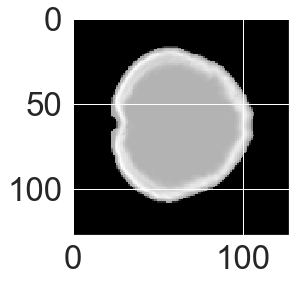

In [63]:
#creo l'array per passarlo poi al file come database
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import cv2

# lista per fare image reading
location_train_dir ='data/train/'
location_train_file_names = [location_train_dir + item for item in train_file_names]
#print(location_test_file_names)

#inizialize stack and resise x
x = io.imread(location_train_file_names[0])
x = cv2.resize(x, dsize=(128,128))
plt.imshow(x, cmap=plt.cm.gray)
print('Grandezza immagini:', x.shape)

#stack images
for img in location_train_file_names[1:]: #parti dalla seconda immagine
    img = io.imread(img)
    img = cv2.resize(img, dsize=(128,128))
    x = np.dstack((x,img))

#reshape and normalise
x = np.rollaxis(x,-1) #(182,218,N)->(N,182,218)
#x = x.reshape(-1, 128, 128, 1).astype('float32')
x = x/255. 
print('TRAIN DATABASE:', x.shape)

#creo lista di labels (y) per metrics
ext = '.png'
y = []
for text in listdir('data/train'):
    fileNameOnly = text[:text.find(ext)]
    y.append(''.join([i for i in fileNameOnly if not i.isdigit()]))

#numero di clusters. (3)
n_clusters = len(np.unique(y))
print('Numero di categorie:', n_clusters)


In [64]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


## Base line K-Means clustering accuracy

In [65]:
new_x = x.reshape(x.shape[0],-1)
print('X shape: ',new_x.shape)

for i, item in enumerate(y):
    if item == 'CT':
        y[i] = '0'
    elif item == 'MRI':
        y[i] = '1'
    else: y[i] = '2'

new_y = np.array(y)
print('Y shape: ',new_y.shape)

kmeans = KMeans(n_clusters=n_clusters, n_init=20, n_jobs=4, random_state=1)
y_pred_kmeans = kmeans.fit_predict(new_x)

X shape:  (851, 16384)
Y shape:  (851,)


In [66]:
k_means_accuracy = metrics.acc(new_y, y_pred_kmeans)
print('L\'accuratezza calcolata con l\'algoritmo KMeans è:', k_means_accuracy)

L'accuratezza calcolata con l'algoritmo KMeans è: 0.3654524089306698


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


## Hyper-params

In [67]:
# to edit!
dims = [new_x.shape[-1], 500, 500, 2000, 3]

# ?
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')

pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 20
batch_size = 16

save_dir = './results'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [68]:
autoencoder, encoder = autoencoder(dims, init=init)

In [69]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(new_x, new_x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights(save_dir + '/ae_weights.h5')

Epoch 1/20
851/851 [==============================] - 5s 6ms/step - loss: 0.0896
Epoch 2/20
851/851 [==============================] - 5s 6ms/step - loss: 0.0530
Epoch 3/20
851/851 [==============================] - 6s 7ms/step - loss: 0.0234
Epoch 4/20
851/851 [==============================] - 6s 7ms/step - loss: 0.0197
Epoch 5/20
851/851 [==============================] - 6s 7ms/step - loss: 0.0198
Epoch 6/20
851/851 [==============================] - 7s 8ms/step - loss: 0.0194
Epoch 7/20
851/851 [==============================] - 10s 11ms/step - loss: 0.0196
Epoch 8/20
851/851 [==============================] - 7s 8ms/step - loss: 0.0192
Epoch 9/20
851/851 [==============================] - 7s 8ms/step - loss: 0.0190
Epoch 10/20
851/851 [==============================] - 7s 8ms/step - loss: 0.0189
Epoch 11/20
851/851 [==============================] - 5s 6ms/step - loss: 0.0190
Epoch 12/20
851/851 [==============================] - 5s 6ms/step - loss: 0.0187
Epoch 13/20
851/851 [==

In [70]:
autoencoder.save_weights(save_dir + '/ae_weights.h5')

In [71]:
autoencoder.load_weights(save_dir + '/ae_weights.h5')

## Build clustering layer

### CluteringLayer

In [72]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [73]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

In [74]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

### Inizialise cluster centers using k-means

In [89]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(new_x))

In [90]:
y_pred_last = np.copy(y_pred)

In [91]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### Deep clustering

In [92]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [93]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

In [94]:
tol = 0.001 # tolerance threshold to stop training

### Training

In [95]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(new_x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        
        if new_y is not None:
            acc = np.round(metrics.acc(new_y, y_pred), 5)
            nmi = np.round(metrics.nmi(new_y, y_pred), 5)
            ari = np.round(metrics.ari(new_y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, new_x.shape[0])]
    loss = model.train_on_batch(x=new_x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= new_x.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final.h5')

/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 0: acc = 0.40188, nmi = 0.00833, ari = 0.00801  ; loss= 0


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 140: acc = 0.39483, nmi = 0.00573, ari = 0.00598  ; loss= 0.02029


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 280: acc = 0.39953, nmi = 0.00719, ari = 0.00759  ; loss= 0.05039


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 420: acc = 0.40423, nmi = 0.01165, ari = 0.01021  ; loss= 0.25426


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 560: acc = 0.40188, nmi = 0.00840, ari = 0.00790  ; loss= 0.05801


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 700: acc = 0.40188, nmi = 0.01051, ari = 0.00941  ; loss= 0.0167


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 840: acc = 0.40188, nmi = 0.01024, ari = 0.00931  ; loss= 0.07791


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 980: acc = 0.40188, nmi = 0.01024, ari = 0.00931  ; loss= 0.02395


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1120: acc = 0.40306, nmi = 0.01051, ari = 0.00992  ; loss= 0.02693


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1260: acc = 0.40423, nmi = 0.01027, ari = 0.00916  ; loss= 0.01888


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1400: acc = 0.40423, nmi = 0.01088, ari = 0.01020  ; loss= 0.01055


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1540: acc = 0.40071, nmi = 0.00997, ari = 0.00973  ; loss= 0.04107


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1680: acc = 0.39835, nmi = 0.00732, ari = 0.00774  ; loss= 0.02708


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1820: acc = 0.39718, nmi = 0.00664, ari = 0.00704  ; loss= 0.02985


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1960: acc = 0.38543, nmi = 0.00528, ari = 0.00520  ; loss= 0.04148


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2100: acc = 0.38543, nmi = 0.00541, ari = 0.00519  ; loss= 0.04238


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2240: acc = 0.38660, nmi = 0.00582, ari = 0.00574  ; loss= 0.02156


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2380: acc = 0.38660, nmi = 0.00585, ari = 0.00582  ; loss= 0.01959


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2520: acc = 0.38308, nmi = 0.00521, ari = 0.00485  ; loss= 0.03646


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2660: acc = 0.38308, nmi = 0.00504, ari = 0.00462  ; loss= 0.04399


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2800: acc = 0.38073, nmi = 0.00430, ari = 0.00391  ; loss= 0.02924


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2940: acc = 0.37485, nmi = 0.00405, ari = 0.00265  ; loss= 0.05235


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3080: acc = 0.38073, nmi = 0.00481, ari = 0.00436  ; loss= 0.04489


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3220: acc = 0.37485, nmi = 0.00372, ari = 0.00289  ; loss= 0.03627


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3360: acc = 0.38190, nmi = 0.00456, ari = 0.00422  ; loss= 0.04395


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3500: acc = 0.38308, nmi = 0.00447, ari = 0.00395  ; loss= 0.02725


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3640: acc = 0.38073, nmi = 0.00468, ari = 0.00421  ; loss= 0.01776


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3780: acc = 0.37838, nmi = 0.00377, ari = 0.00326  ; loss= 0.01992


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3920: acc = 0.38190, nmi = 0.00485, ari = 0.00434  ; loss= 0.02844


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4060: acc = 0.38190, nmi = 0.00460, ari = 0.00411  ; loss= 0.08291


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4200: acc = 0.38073, nmi = 0.00437, ari = 0.00381  ; loss= 0.03264


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4340: acc = 0.38543, nmi = 0.00483, ari = 0.00469  ; loss= 0.02743


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4480: acc = 0.38778, nmi = 0.00533, ari = 0.00536  ; loss= 0.02878


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4620: acc = 0.38778, nmi = 0.00554, ari = 0.00566  ; loss= 0.04103


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4760: acc = 0.38190, nmi = 0.00450, ari = 0.00400  ; loss= 0.03183


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4900: acc = 0.38073, nmi = 0.00417, ari = 0.00369  ; loss= 0.04521


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 5040: acc = 0.38778, nmi = 0.00556, ari = 0.00560  ; loss= 0.03133


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 5180: acc = 0.38660, nmi = 0.00479, ari = 0.00477  ; loss= 0.02042


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 5320: acc = 0.38895, nmi = 0.00547, ari = 0.00545  ; loss= 0.03249


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 5460: acc = 0.39013, nmi = 0.00562, ari = 0.00563  ; loss= 0.06885


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 5600: acc = 0.38778, nmi = 0.00614, ari = 0.00587  ; loss= 0.02628


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 5740: acc = 0.38778, nmi = 0.00568, ari = 0.00563  ; loss= 0.03154
Iter 5880: acc = 0.38778, nmi = 0.00568, ari = 0.00563  ; loss= 0.03262
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [96]:
model.load_weights(save_dir + '/DEC_model_final.h5')

In [97]:
# Eval.
q = model.predict(new_x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if new_y is not None:
    acc = np.round(metrics.acc(new_y, y_pred), 5)
    nmi = np.round(metrics.nmi(new_y, y_pred), 5)
    ari = np.round(metrics.ari(new_y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.38778, nmi = 0.00568, ari = 0.00563  ; loss= 0.03262


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [87]:
#print(y_pred)
#print(new_y)

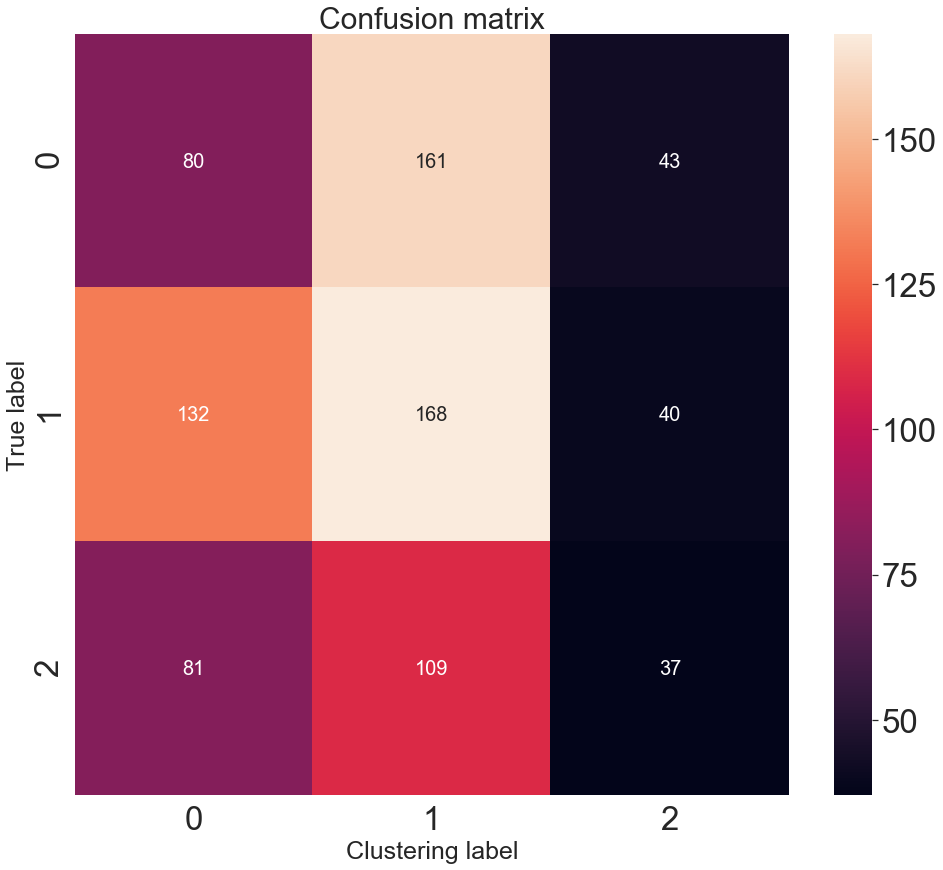

In [98]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)

confusion_matrix = sklearn.metrics.confusion_matrix([int(i) for i in y], y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

In [100]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = new_y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


0.38777908343125733

In [102]:
ind

array([[0, 1],
       [1, 0],
       [2, 2]])

## Convolutional autoencoder

In [145]:
from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
import numpy as np

In [146]:
def autoencoderConv2D_2(img_shape=(128, 128, 1)):
    """
    Conv2D auto-encoder model.
    Arguments:
        img_shape: e.g. (28, 28, 1) for MNIST
    return:
        (autoencoder, encoder), Model of autoencoder and model of encoder
    """
    input_img = Input(shape=img_shape)
    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(input_img)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    shape_before_flattening = K.int_shape(x)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    x = Flatten()(x)
    encoded = Dense(10, activation='relu', name='encoded')(x)

    # Decoder
    x = Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(encoded)
    # Reshape into an image of the same shape as before our last `Flatten` layer
    x = Reshape(shape_before_flattening[1:])(x)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [147]:
autoencoder, encoder = autoencoderConv2D_2()

In [148]:
autoencoder.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 8)         1160      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 8)         584       
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
encoded (Dense)              (None, 10)                20490     
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              22528    

In [153]:
pretrain_epochs = 50
batch_size = 16

In [154]:
autoencoder.compile(optimizer='adadelta', loss='mse')

In [155]:
new_x = new_x.reshape(-1, 128, 128, 1).astype('float32')
out_x = new_x[:,:-4,:-4]
print(out_x.shape)

(851, 124, 124, 1)


In [156]:
autoencoder.fit(new_x, out_x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights(save_dir+'/conv_ae_weights.h5')

Epoch 1/50
851/851 [==============================] - 6s 7ms/step - loss: 0.0070
Epoch 2/50
851/851 [==============================] - 6s 7ms/step - loss: 0.0067
Epoch 3/50
851/851 [==============================] - 6s 7ms/step - loss: 0.0064
Epoch 4/50
851/851 [==============================] - 6s 7ms/step - loss: 0.0065
Epoch 5/50
851/851 [==============================] - 6s 7ms/step - loss: 0.0063
Epoch 6/50
851/851 [==============================] - 6s 7ms/step - loss: 0.0061
Epoch 7/50
851/851 [==============================] - 6s 7ms/step - loss: 0.0056
Epoch 8/50
851/851 [==============================] - 5s 6ms/step - loss: 0.0057
Epoch 9/50
851/851 [==============================] - 6s 7ms/step - loss: 0.0054
Epoch 10/50
851/851 [==============================] - 6s 7ms/step - loss: 0.0053
Epoch 11/50
851/851 [==============================] - 6s 7ms/step - loss: 0.0054
Epoch 12/50
851/851 [==============================] - 6s 7ms/step - loss: 0.0052
Epoch 13/50
851/851 [====

In [157]:
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')

In [158]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer='adam', loss='kld')

In [159]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(new_x))

In [160]:
y_pred_last = np.copy(y_pred)

In [161]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

In [162]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

In [163]:
tol = 0.001 # tolerance threshold to stop training

In [164]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(new_x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        
        if new_y is not None:
            acc = np.round(metrics.acc(new_y, y_pred), 5)
            nmi = np.round(metrics.nmi(new_y, y_pred), 5)
            ari = np.round(metrics.ari(new_y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, new_x.shape[0])]
    loss = model.train_on_batch(x=new_x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= new_x.shape[0] else 0

model.save_weights(save_dir + '/conv_DEC_model_final.h5')

/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 0: acc = 0.36193, nmi = 0.00454, ari = 0.00277  ; loss= 0


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 140: acc = 0.36310, nmi = 0.00445, ari = 0.00269  ; loss= 0.05642


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 280: acc = 0.37955, nmi = 0.00314, ari = 0.00157  ; loss= 0.06912


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 420: acc = 0.37133, nmi = 0.00316, ari = 0.00139  ; loss= 0.04323


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 560: acc = 0.38660, nmi = 0.00424, ari = 0.00379  ; loss= 0.10339


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 700: acc = 0.37838, nmi = 0.00475, ari = 0.00313  ; loss= 0.03745


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 840: acc = 0.36898, nmi = 0.00369, ari = 0.00167  ; loss= 0.06824


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 980: acc = 0.38190, nmi = 0.00428, ari = 0.00274  ; loss= 0.0232


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1120: acc = 0.37368, nmi = 0.00586, ari = 0.00334  ; loss= 0.03346


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1260: acc = 0.38543, nmi = 0.00532, ari = 0.00381  ; loss= 0.04593


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1400: acc = 0.37603, nmi = 0.00450, ari = 0.00262  ; loss= 0.04652


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1540: acc = 0.37015, nmi = 0.00535, ari = 0.00297  ; loss= 0.06233


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1680: acc = 0.37485, nmi = 0.00477, ari = 0.00265  ; loss= 0.01297


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1820: acc = 0.37368, nmi = 0.00508, ari = 0.00291  ; loss= 0.02498


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1960: acc = 0.37720, nmi = 0.00470, ari = 0.00279  ; loss= 0.02662


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2100: acc = 0.37368, nmi = 0.00470, ari = 0.00252  ; loss= 0.02738


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2240: acc = 0.37485, nmi = 0.00498, ari = 0.00310  ; loss= 0.03611


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2380: acc = 0.37368, nmi = 0.00516, ari = 0.00297  ; loss= 0.01901


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2520: acc = 0.37250, nmi = 0.00451, ari = 0.00262  ; loss= 0.02225


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2660: acc = 0.37133, nmi = 0.00416, ari = 0.00215  ; loss= 0.02179


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2800: acc = 0.37250, nmi = 0.00443, ari = 0.00255  ; loss= 0.03173
Iter 2940: acc = 0.37250, nmi = 0.00443, ari = 0.00255  ; loss= 0.0267
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [ ]:
model.load_weights(save_dir + '/conv_DEC_model_final.h5')

In [166]:
# Eval.
q = model.predict(new_x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if new_y is not None:
    acc = np.round(metrics.acc(new_y, y_pred), 5)
    nmi = np.round(metrics.nmi(new_y, y_pred), 5)
    ari = np.round(metrics.ari(new_y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.37250, nmi = 0.00443, ari = 0.00255  ; loss= 0.0267


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


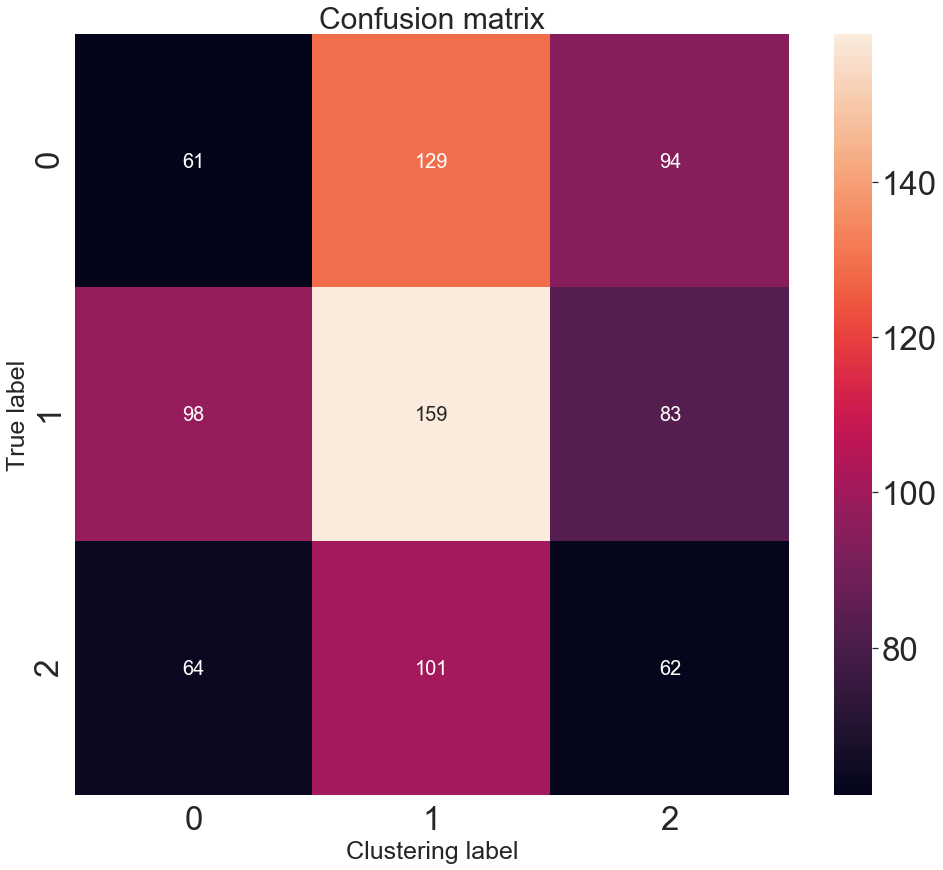

In [168]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix([int(i) for i in y], y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

In [169]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = new_y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


0.372502937720329

In [170]:
ind

array([[0, 2],
       [1, 1],
       [2, 0]])

## Model to train clustering and autoencoder at the same time (Convolutional)

In [172]:
autoencoder, encoder = autoencoderConv2D_2()
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
                           outputs=[clustering_layer, autoencoder.output])

In [174]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(new_x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [175]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

In [189]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(new_x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if new_y is not None:
            acc = np.round(metrics.acc(new_y, y_pred), 5)
            nmi = np.round(metrics.nmi(new_y, y_pred), 5)
            ari = np.round(metrics.ari(new_y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, new_x.shape[0])]
    loss = model.train_on_batch(x=new_x[idx], y=[p[idx], out_x[idx]])
    index = index + 1 if (index + 1) * batch_size <= new_x.shape[0] else 0

model.save_weights(save_dir + '/conv_b_DEC_model_final.h5')

/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 0: acc = 0.36193, nmi = 0.00454, ari = 0.00277  ; loss= 0.0267


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 140: acc = 0.36193, nmi = 0.00517, ari = 0.00376  ; loss= [0.01431 0.0666  0.00765]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 280: acc = 0.36663, nmi = 0.00583, ari = 0.00418  ; loss= [0.00814 0.04426 0.00371]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 420: acc = 0.36193, nmi = 0.00492, ari = 0.00336  ; loss= [0.01366 0.05969 0.00769]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 560: acc = 0.37015, nmi = 0.00585, ari = 0.00403  ; loss= [0.00935 0.03832 0.00552]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 700: acc = 0.36898, nmi = 0.00539, ari = 0.00366  ; loss= [0.01069 0.04947 0.00575]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 840: acc = 0.37133, nmi = 0.00506, ari = 0.00326  ; loss= [0.00848 0.03402 0.00508]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 980: acc = 0.37250, nmi = 0.00512, ari = 0.00332  ; loss= [0.00873 0.04113 0.00462]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1120: acc = 0.36663, nmi = 0.00424, ari = 0.00252  ; loss= [0.01135 0.06711 0.00464]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1260: acc = 0.36780, nmi = 0.00389, ari = 0.00210  ; loss= [0.00981 0.03215 0.00659]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1400: acc = 0.36780, nmi = 0.00373, ari = 0.00194  ; loss= [0.01333 0.0783  0.0055 ]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1540: acc = 0.36780, nmi = 0.00389, ari = 0.00210  ; loss= [0.00803 0.02679 0.00535]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1680: acc = 0.36545, nmi = 0.00335, ari = 0.00145  ; loss= [0.00718 0.03084 0.0041 ]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1820: acc = 0.36663, nmi = 0.00342, ari = 0.00164  ; loss= [0.00821 0.02172 0.00604]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1960: acc = 0.36663, nmi = 0.00348, ari = 0.00176  ; loss= [0.0166  0.0369  0.01291]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2100: acc = 0.36663, nmi = 0.00330, ari = 0.00148  ; loss= [0.00939 0.04737 0.00466]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2240: acc = 0.36780, nmi = 0.00379, ari = 0.00206  ; loss= [0.00812 0.02974 0.00515]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2380: acc = 0.36780, nmi = 0.00374, ari = 0.00192  ; loss= [0.00885 0.0319  0.00566]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2520: acc = 0.36663, nmi = 0.00355, ari = 0.00182  ; loss= [0.01075 0.02882 0.00787]


/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2660: acc = 0.36663, nmi = 0.00355, ari = 0.00182  ; loss= [0.00623 0.01877 0.00435]
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.
